In [1]:
using CSV
using DataFrames
using Plots
using LaTeXStrings
using IJulia
using LinearAlgebra
using StaticArrays
using FLoops
using CUDA
using BenchmarkTools
gr()


Plots.GRBackend()

In [2]:
CUDA.versioninfo()

CUDA toolkit 11.6, artifact installation
NVIDIA driver 512.59.0, for CUDA 11.6
CUDA driver 11.6

Libraries: 
- CUBLAS: 11.8.1
- CURAND: 10.2.9
- CUFFT: 10.7.0
- CUSOLVER: 11.3.2
- CUSPARSE: 11.7.1
- CUPTI: 16.0.0
- NVML: 11.0.0+512.59
- CUDNN: 8.30.2 (for CUDA 11.5.0)
- CUTENSOR: 1.4.0 (for CUDA 11.5.0)

Toolchain:
- Julia: 1.7.2
- LLVM: 12.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80

1 device:
  0: NVIDIA GeForce GTX 1050 Ti with Max-Q Design (sm_61, 3.927 GiB / 4.000 GiB available)


In [3]:
function vec_triu(M::AbstractMatrix{T}) where T
    m, n = size(M)
    m == n || throw(error("not square"))
    l = n*(n+1) ÷ 2
    v = zeros(T,l)
    k = 0
    @inbounds for i in 1:n
        for j in 1:i
            v[k + j] = M[j, i]
        end
        k += i
    end
    v
end

function idx_nearest(k_space::Vector{Float64},k::Float64)
    return argmin(abs.(k_space.-k))
end


function SSF_CUDA(X::CuArray{Float32},Y::CuArray{Float32},Z::CuArray{Float32},k_vec::Vector{Float32})
    return @inbounds sum(cos.(k_vec[1].*X.+k_vec[2].*Y.+k_vec[3].*Z))
        + sum(sin.(k_vec[1].*X.+k_vec[2].*Y.+k_vec[3].*Z))
end
    
function SSF_wrapper(RA::DataFrame, RB::DataFrame,k_df::DataFrame, k_bins::Vector{Float64})
    @assert size(RA) == size(RB)
    
    # Array to count number of samples in each bin
    num_samples = zeros(Int32,length(k_bins))
    
    # Array to store the SSF of all k vector
    ssf = zeros(Float32,length(k_bins))
    
    # The diff matrices:
    X = CuArray{Float32}(vec_triu((transpose(repeat(RA.x,1,length(RA.x))).-repeat(RB.x,1,length(RB.x)))))
    Y = CuArray{Float32}(vec_triu((transpose(repeat(RA.y,1,length(RA.y))).-repeat(RB.y,1,length(RB.y)))))
    Z = CuArray{Float32}(vec_triu((transpose(repeat(RA.z,1,length(RA.z))).-repeat(RB.z,1,length(RB.z)))))
    half_N = length(RA.x) #Total number of particles
    
    counter = 0
    N_tot = length(k_df.k) # Total number of k-vectors
    tic = time()
    
    # Loop over all k vectors
    for k_row in eachrow(k_df)
        bin = idx_nearest(k_bins,k_row.k) #Find the correct bin
        num_samples[bin] +=1               #Increase the number of sampels in that bin
        
        k_vec = Vector{Float32}([k_row.k1,k_row.k2,k_row.k3])
        ssf[bin] += SSF_CUDA(X,Y,Z,k_vec)/half_N
        
        
        counter += 1

    end
    toc = time()
    println("Time elapsed: $(toc-tic)s for $(counter) runs.")
    # Replace num_samples = 0 by 1 to avoid dividing by zero.
    num_samples[num_samples.==0] .= 1
    return k_bins, ssf./num_samples
end
    
    

SSF_wrapper (generic function with 1 method)

### Read the dump file

In [4]:
N = 16000
f_path = "../Sim_results/bcc16000_v2/pos_014K.dump"
df = DataFrame(CSV.File(f_path; skipto=10, limit=N,delim = " ", header = ["id", "_type", "x", "y", "z"],ignorerepeated=true,ntasks = 1))
dfA = df[df._type.==1,:]
dfB = df[df._type.==2,:];

### Import the k-vectors and $S(\vec{k})$ from freud

In [5]:
k_df = DataFrame(CSV.File("k_points_fraud.csv"))
k_df[!,:k] = sqrt.(k_df.k1.^2+k_df.k2.^2+k_df.k3.^2) # Add a row with the length of each k-vector
Sk_df = DataFrame(CSV.File("S_k_fraud.csv"))
k_space = Array(range(minimum(k_df.k), maximum(k_df.k),length = 100));

In [6]:
bin_centers = Array([ 0.075     ,  0.22500001,  0.375     ,  0.52500004,  0.67500001,
        0.82500005,  0.97500002,  1.125     ,  1.2750001 ,  1.42499995,
        1.57500005,  1.72500014,  1.875     ,  2.0250001 ,  2.17500019,
        2.32500005,  2.47500014,  2.625     ,  2.7750001 ,  2.92500019,
        3.07500005,  3.22500014,  3.375     ,  3.5250001 ,  3.67500019,
        3.82500029,  3.97500014,  4.125     ,  4.27500057,  4.42500019,
        4.57499981,  4.72500038,  4.875     ,  5.02500057,  5.17500019,
        5.32499981,  5.47500038,  5.625     ,  5.77500057,  5.92500019,
        6.07499981,  6.22500038,  6.375     ,  6.52500057,  6.67500019,
        6.82500029,  6.97500038,  7.125     ,  7.27500057,  7.42500019,
        7.57500029,  7.72500038,  7.875     ,  8.02500057,  8.17500019,
        8.32500076,  8.47500038,  8.625     ,  8.77500057,  8.92500019,
        9.07500076,  9.22500038,  9.375     ,  9.52500057,  9.67500019,
        9.82500076,  9.97500038, 10.125     , 10.27500057, 10.42500019,
       10.57500076, 10.72500038, 10.875     , 11.02500057, 11.17500019,
       11.32500076, 11.47500038, 11.625     , 11.77500057, 11.92500019,
       12.07500076, 12.22500038, 12.375     , 12.52500057, 12.67500114,
       12.82500076, 12.97500038, 13.125     , 13.27500057, 13.42500114,
       13.57500076, 13.72500038, 13.875     , 14.02500057, 14.17500114,
       14.32500076, 14.47500038, 14.625     , 14.77500057, 14.92500114]);

### Calculate the static structure function

In [7]:
# S_k for A-A
k_AA, S_k_calculated_AA = SSF_wrapper(dfA, dfA, sort(k_df,[:k])[:,:],bin_centers);

Time elapsed: 1326.62299990654s for 174418 runs.


In [8]:
# S_k for A-B
k_AB, S_k_calculated_AB = SSF_wrapper(dfA, dfB, sort(k_df,[:k])[:,:],bin_centers);

Time elapsed: 1303.6849999427795s for 174418 runs.


In [9]:
k_BB, S_k_calculated_BB = SSF_wrapper(dfB, dfB, sort(k_df,[:k])[:,:],bin_centers);

Time elapsed: 1299.7740001678467s for 174418 runs.


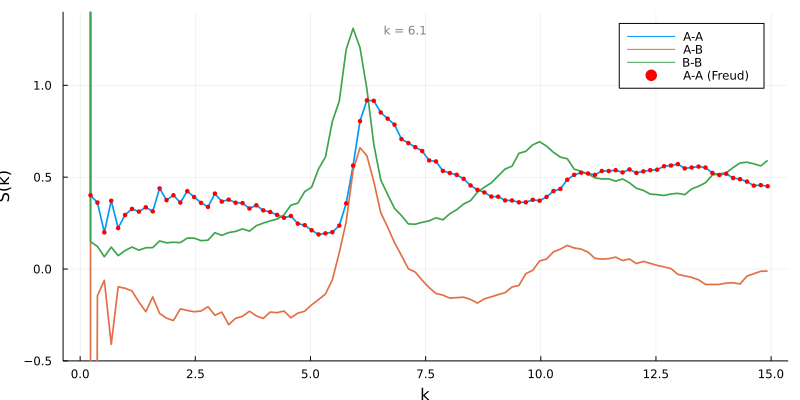

In [54]:
lw = 1.7
p1 = plot(bin_centers,S_k_calculated_AA.-0.5,label = "A-A", 
    ylim=(-0.5,1.4),grid = true, size=(800,400),xlabel="k", ylabel="S(k)", linewidth = lw,
    xticks = range(0, 15,length =7))
p1 = plot!(bin_centers,S_k_calculated_AB,label = "A-B", linewidth = lw)
p1 = plot!(bin_centers,S_k_calculated_BB.-0.5,label = "B-B", linewidth = lw)
p1 = plot!(bin_centers,Sk_df.S_k,label = "A-A (Freud)", seriestype = :scatter, markersize = 2.5,markerstrokewidth = 0.0 , color = "red")
p1 = plot!([6.1], seriestype="vline", color = "grey",line = :scatter, label = "")
p1 = annotate!(7.5, 1.3, text("k = 6.1", :grey, :right, 8))

In [55]:
savefig(p1,"SSF_withLine2.pdf")

In [18]:
a = [1,2,3,4,5,6]
a[1:2:end]

3-element Vector{Int64}:
 1
 3
 5